Quarter Car Model (Sprung and Unsprung Mass with Tire Stiffness)

In [1]:
!git config --global user.name "Isaac"
!git config --global user.email "ikehonebrink1@gmail.com"

In [2]:
from google.colab import auth
auth.authenticate_user()


In [22]:
!git init
!git status

Reinitialized existing Git repository in /content/.git/
On branch main
nothing to commit, working tree clean


In [23]:
!git remote add origin https://github.com/ikehone1/Vehicle-Dynamics-Simulator.git

error: remote origin already exists.


In [24]:
!git add .
!git commit -m "Initial quarter-car suspension model"

On branch main
nothing to commit, working tree clean


In [25]:
!git add .
!git commit -m "Initial commit"
!git push -u origin main


On branch main
nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [20]:
!git branch

* main


In [26]:
!pwd
!ls

/content
sample_data


In [3]:
import numpy as np
#Variables
m_s = 300 #kg   car mass
m_u = 40 #kg   tire+rim+brakes
k_s = 30000 # N/m
c_s = 3000 # Ns/m
k_t = 200000 # N/m   tire stiffness
z_s0 = 0.0
z_u0 = 0.0
z1_s0 = 0.0
z1_u0 = 0.0
A = 0.05 # m
w = 10 # rad/s
t = 0.0

In [4]:
#Road input
def road_input(A, w, t):
  z_r = A * np.sin(w * t)
  z1_r = A * w * np.cos(w * t)
  return z_r, z1_r

In [5]:
#Car Vertical Acceleration
def quartcar_accel(z_s0, z_u0, z1_s0, z1_u0, t):
  z_r, z1_r = road_input(A, w, t)
  a_s = (-k_s*(z_s0 - z_u0) - c_s*(z1_s0 - z1_u0)) / m_s  # Sprung Mass Acceleration
  a_u = (k_s*(z_s0 - z_u0) + c_s*(z1_s0 - z1_u0) - k_t*(z_u0 - z_r)) / m_u   #  Unsprung Mass Acceleration
  return a_s, a_u

a_s, a_u = quartcar_accel(z_s0, z_u0, z1_s0, z1_u0, t)

In [6]:
#RK4 Step
def quarter_car_rk4_step(z_s, z1_s, z_u, z1_u, t, dt):

  def f(z_s, z1_s, z_u, z1_u, t):
        a_s, a_u = quartcar_accel(z_s, z_u, z1_s, z1_u, t)  #changes function to equal a_s and a_u instead of z1_s and z1_u
        return np.array([
            z1_s,
            a_s,
            z1_u,
            a_u
        ])
  X = np.array([z_s, z1_s, z_u, z1_u])  #used to replace writing the whole array in each RK4 step
              # z_s, z1_s, z_u, z1_u
  k1 = f(*X, t) # * means that Python will unpack and remove brackets of array X. The same as f(z_s, z1_s, z_u, z1_u, t)
  k2 = f(*(X + (0.5*k1*dt)), (t + 0.5*dt))
  k3 = f(*(X + (0.5*k2*dt)), (t + 0.5*dt))
  k4 = f(*(X + k3*dt), t + dt)
  # X is used to calculate the position and velocity of the wheel at each k step.
  X_next = X + dt*((k1 + 2*k2 + 2*k3 + k4)/6)

  return X_next

In [7]:
#RK4 Loop
dt = 0.01
t = 0.0
t_end = 6.0

z_s, z1_s = 0.0, 0.0
z_u, z1_u = 0.0, 0.0

Time, Zs, Zu = [], [], []
Zr = []
Energy = []

while t < t_end:
  z_s, z1_s, z_u, z1_u = quarter_car_rk4_step(z_s, z1_s, z_u, z1_u, t, dt)
  z_r, _ = road_input(A, w, t)
  ERG = (0.5*m_s*z1_s**2) + (0.5*k_s*(z_s - z_u)**2) + (0.5*m_u*z1_u**2) + (0.5*k_t*(z_u-z_r)**2)

  Time.append(t)
  Zs.append(z_s)
  Zu.append(z_u)
  Zr.append(z_r)
  Energy.append(ERG)
  t += dt

In [8]:
#print(f'Zs: {Zs}')
#print(f'Zu: {Zu}')
#print(f'Zr: {Zr}')
#print(f'Energy: {Energy}')

In [9]:
#Plotting Function
def simple_plot(x_value, y_value, xlabel, ylabel, title):
  import matplotlib.pyplot as plt
  plt.figure()
  plt.plot(x_value, y_value)
  plt.xlabel(f'{xlabel}')
  plt.ylabel(f'{ylabel}')
  plt.title(f'{title}' )
  plt.grid
  plt.show()


def plot_overlay(x_value, y1_value, y2_value, xlabel, ylabel, title, line1, line2):
  import matplotlib.pyplot as plt
  plt.figure()
  plt.plot(x_value, y1_value, label=line1)
  plt.plot(x_value, y2_value, label=line2, linestyle='--')
  plt.xlabel(f'{xlabel}')
  plt.ylabel(f'{ylabel}')
  plt.title(f'{title}')
  plt.grid()
  plt.legend()
  plt.show()

In [10]:
#Tire Deflection
tire_deflect = np.array(Zu) - np.array(Zr)
#print(tire_deflect)

susp_travel = np.array(Zs) - np.array(Zu)
#print(susp_travel)

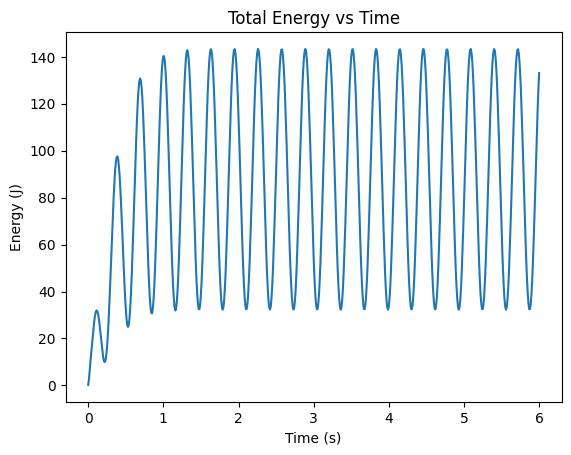

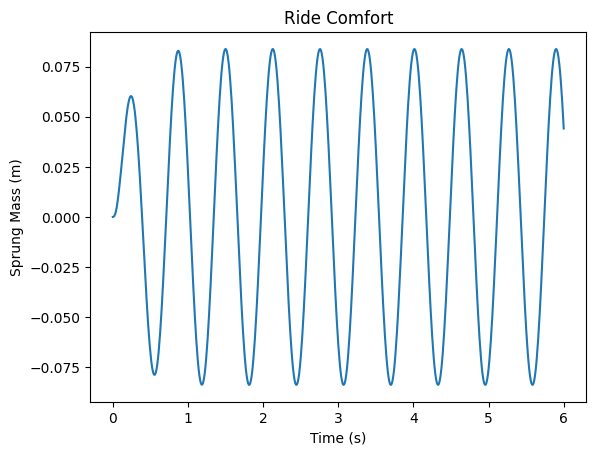

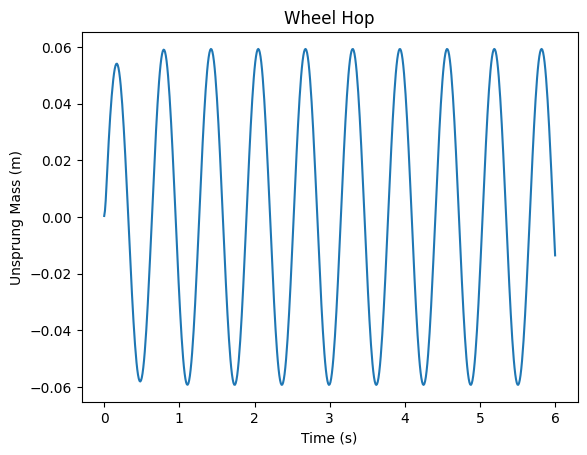

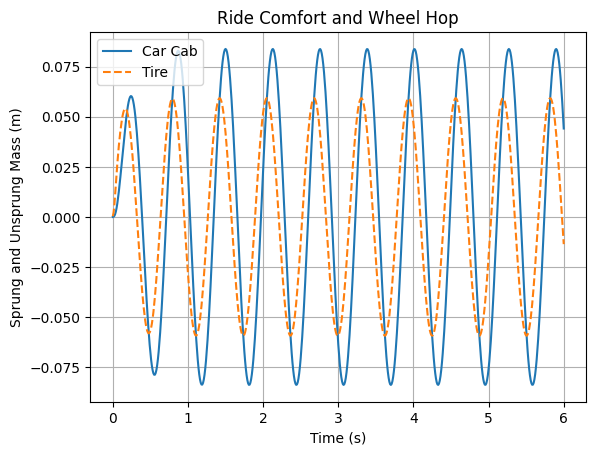

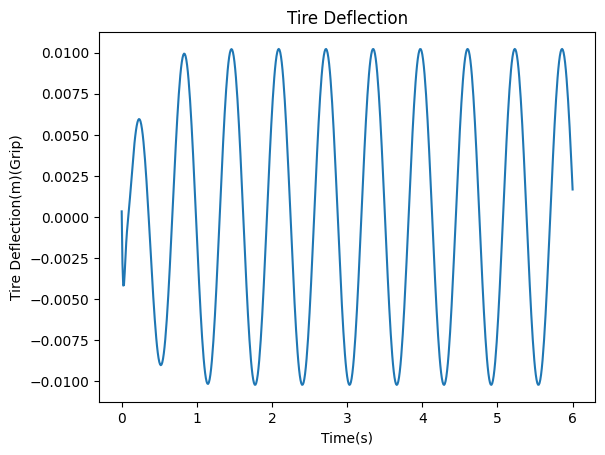

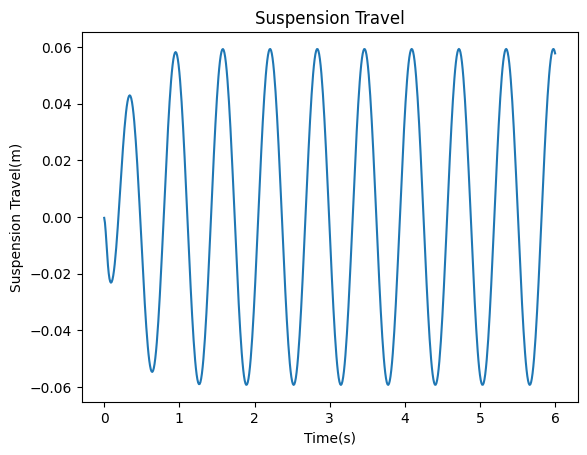

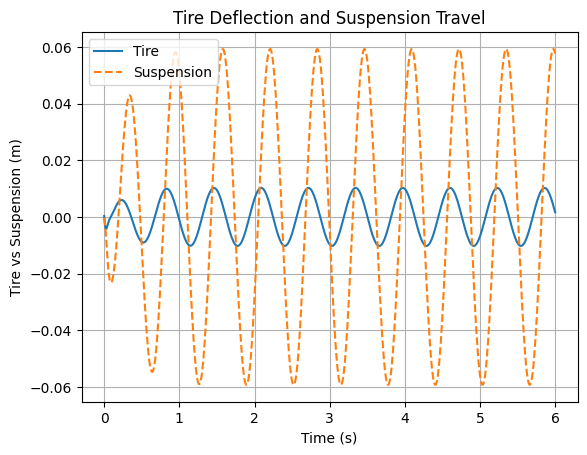

In [11]:
simple_plot(Time, Energy, 'Time (s)', 'Energy (J)', 'Total Energy vs Time')
simple_plot(Time, Zs, 'Time (s)', 'Sprung Mass (m)', 'Ride Comfort')
simple_plot(Time, Zu, 'Time (s)', 'Unsprung Mass (m)', 'Wheel Hop')
plot_overlay(Time, Zs, Zu, 'Time (s)', 'Sprung and Unsprung Mass (m)', 'Ride Comfort and Wheel Hop', 'Car Cab', 'Tire')
simple_plot(Time, tire_deflect, 'Time(s)', 'Tire Deflection(m)(Grip)', 'Tire Deflection')
simple_plot(Time, susp_travel, 'Time(s)', 'Suspension Travel(m)', 'Suspension Travel' )
plot_overlay(Time, tire_deflect, susp_travel, "Time (s)", "Tire vs Suspension (m)", "Tire Deflection and Suspension Travel", 'Tire', 'Suspension')